In [192]:
from sklearn.svm import SVC
from HelperFunctions_ import classesInLabels
import numpy as np
import copy

def SeperateDataLabels(data,labels, seperation): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    #Check the labels and the seperation have the same number of classes or not 
    # Will remove the classes not in the seperation array. 
    
    if(len(seperation) == 2): 

        classesInSeperation = []

        for i in range(len(seperation)): 
            for j in range(len(seperation[i])): 
                if(not(seperation[i][j] in classesInSeperation)): 
                    classesInSeperation.append(seperation[i][j])

        classesInSeperation.sort()
        classesInSeperation = np.array(classesInSeperation)
        cIL = np.array(classesInLabels(labels))

        #Checks if the seperation and the labels have same amount of classes. If not return -1 ????
        if(not(np.array_equal(cIL, classesInSeperation))): 

            for i in range(len(cIL)): 
                if(not(cIL[i] in classesInSeperation)):
                    train_data = train_data[train_labels != cIL[i]]
                    train_labels = train_labels[train_labels != cIL[i]]

        if(len(classesInLabels(labels)) > 2):  #Remove this if not work
            for i in range(len(seperation)): 
                for j in range(len(seperation[i])):
                    if(seperation[i][j] != min(seperation[i])):
                        train_labels[train_labels == seperation[i][j]] = min(seperation[i])
        
        return train_data, train_labels
        
    else: 
        print("The seperation needs to be 2 in length. For 1v1 classification")
        return -1



def BranchDataLabels(data, labels, tree_branches): 

    """
    Takes in data and labes for the SVM Desion Tree. 
    Makes the labels for every branch 1v1 classes. 

    """

    if(len(tree_branches) > 0): 
        if(len(tree_branches[0]) == 2): 

            #Seperating the classes on the first branch of the data and the labels.
            data_and_labels_branches = {0 : SeperateDataLabels(data, labels, tree_branches[0])}
            
            for i in range(1,len(tree_branches)): 
                data_and_labels = []
                for j in range(len(tree_branches[i])): 
                    if(len(tree_branches[i][j]) == 2):
                            data_and_labels.append(SeperateDataLabels(data,labels,tree_branches[i][j]))
                    else: 
                        data_and_labels.append([])
                data_and_labels_branches[i] = data_and_labels

            return data_and_labels_branches
        
        else: 
            return -1


def SvmBranchModelTrain(data_and_labels_branches): 

    svm_branch_models = {}

    svm = SVC()
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = SVC()
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models[i] = svm_models

    return svm_branch_models


def SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models): 

    svm_branch_models_ = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models_[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = copy.deepcopy(svm_branch_models[i][j]) 
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models_[i] = svm_models

    return svm_branch_models_
    

def SvmBranchModelPredict(data, svm_branch_models, tree_branch, sub_data_return = 0): 
    
    test_data = copy.deepcopy(data)
    
    predicted_branch_labels = {}
    sub_data_branch = {}
    sub_data_sub_branch = []

    svm = svm_branch_models[0]
    yout = svm.predict(test_data)

    predicted_branch_labels[0] = yout
    sub_data_branch[0] = test_data

    sub_data_1 = test_data[yout == min(svm.classes_)]
    sub_data_2 = test_data[yout == max(svm.classes_)]

    if(min(svm.classes_) in tree_branch[0][0]): 
        sub_data_sub_branch.append(sub_data_1)
    else: 
        sub_data_sub_branch.append(sub_data_2)

    if(min(svm.classes_) in tree_branch[0][1]): 
        sub_data_sub_branch.append(sub_data_1)
    else: 
        sub_data_sub_branch.append(sub_data_2)

    sub_data_branch[1] = sub_data_sub_branch

    for i in range(1,len(svm_branch_models)):
        predicted_labels = []
        sub_data_sub_branch = []
        for j in range(len(svm_branch_models[i])): 
            if(svm_branch_models[i][j] != False):
                sub_data = sub_data_branch[i][j]
                svm = svm_branch_models[i][j]
                yout = svm.predict(sub_data)

                predicted_labels.append(yout)

                if(i <= len(svm_branch_models)):     
                    sub_data_1 = sub_data[yout == min(svm.classes_)]
                    sub_data_2 = sub_data[yout == max(svm.classes_)]

                    if(min(svm.classes_) in tree_branch[i][j][0]):
                        sub_data_sub_branch.append(sub_data_1)
                    else: 
                        sub_data_sub_branch.append(sub_data_2)
                     
                    if(min(svm.classes_) in tree_branch[i][j][1]):
                            sub_data_sub_branch.append(sub_data_1)
                    else: 
                        sub_data_sub_branch.append(sub_data_2)
            else: 
                predicted_labels.append([])

        predicted_branch_labels[i] = predicted_labels
        
        if((i-1) <= len(svm_branch_models)): 
            sub_data_branch[i+1] = sub_data_sub_branch

    if(sub_data_return == 0): 
        return predicted_branch_labels
    
    if(sub_data_return == 1): 
        return predicted_branch_labels, sub_data_branch



def combineLabels(predicted_labels, tree_branch): 

    pl = copy.deepcopy(predicted_labels)
    """
    Combine the result from the desion tree. Should be automated. 
    """
    #if(len(pl) == len(tree_branch)): 
    for i in range(len(pl)-2,0,-1): 
        for j in range(len(pl[i])): 
            for k in range(len(tree_branch[i][j])):
                for l in range(len(tree_branch[i][j][k])): 
                    if(tree_branch[i+1][j]):
                        if(tree_branch[i][j][k]):
                            try: 
                                if(min(tree_branch[i][j][k]) in tree_branch[i+1][j][l]):
                                    yout = pl[i][j] 
                                    yout_sub_class = pl[i+1][j]

                                    class_diff = np.abs(len(yout[yout == min(tree_branch[i][j][k])]) - len(yout_sub_class))
                                    for x in range(len(yout)): 
                                        if(yout[x] == min(tree_branch[i][j][k])):
                                            if(class_diff < len(yout_sub_class)):
                                                yout[x] = yout_sub_class[class_diff] 
                                                class_diff += 1
                                    pl[i][j] = yout
                                
                            except: 
                                None
    

    #Collecting the labels from the second branch layer to the first layer. 
    #Cobime the two second layers to the final labeling. 

    if(len(pl[1][0]) and not(len(pl[1][1]))): 
        yout_sub_1 = pl[1][0]
        yout_sub_2 = []
    
    elif(len(pl[1][1]) and not(len(pl[1][0]))):
        yout_sub_1 = []
        yout_sub_2 = pl[1][1]

    else: 
        yout_sub_1 = pl[1][0]
        yout_sub_2 = pl[1][1]

    yout = pl[0]

    if(yout_sub_1 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][1])]) - len(yout_sub_2))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][1]):
                if(class_diff < len(yout_sub_2)):
                    yout[x] = yout_sub_2[class_diff] 
                    class_diff += 1
        #print(class_diff)

    elif(yout_sub_2 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][0])]) - len(yout_sub_1))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(class_diff < len(yout_sub_1)):
                    yout[x] = yout_sub_1[class_diff] 
                    class_diff += 1
        #print(class_diff)

    else:
        count_sub_1 = 0 
        count_sub_2 = 0 
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(count_sub_1 < len(yout_sub_1)):
                    yout[x] = yout_sub_1[count_sub_1] 
                    count_sub_1 += 1
            if(yout[x] in tree_branch[0][1]):
                if(count_sub_2 < len(yout_sub_2)): 
                    yout[x] = yout_sub_2[count_sub_2] 
                    count_sub_2 += 1
    return yout



def RetrieveSubData(data,labels, sub_tree_branch): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    seperation = np.array(sub_tree_branch[0] + sub_tree_branch[1])

    classes = classesInLabels(labels)
    remove_classes = []

    for i in range(len(classesInLabels(labels))): 
        if(not(classes[i] in seperation)): 
            remove_classes.append(classes[i])
            

    for i in range(len(remove_classes)):
        if(remove_classes[i] in labels):
            train_data = train_data[train_labels != remove_classes[i]]
            train_labels = train_labels[train_labels != remove_classes[i]]
        
    return train_data, train_labels

def classesSvmBranches(svm_tree_branch):
    cSB = [svm_tree_branch[0].classes_]
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].classes_)
        cSB.append(branch)
    
    return cSB

def SupportVectorsSvmBranches(svm_tree_branch):
    cSB = []
    cSB.append(svm_tree_branch[0].n_support_)
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].n_support_)
        cSB.append(branch)
    
    return cSB

def TotalAndMeanSupportVectors(support_vectors_array): 

    all_support_vectors = []
    for i in range(len(support_vectors_array)): 
        for j in range(len(support_vectors_array[i])):
                try:
                    all_support_vectors.append(support_vectors_array[i][j][0])
                    all_support_vectors.append(support_vectors_array[i][j][1])
                except: 
                    all_support_vectors.append(support_vectors_array[i][j])

    total_support_vector = np.sum(all_support_vectors)
    mean_support_vector = np.mean(all_support_vectors)     

    return total_support_vector, mean_support_vector

def MeanAccuracy(data_and_labels_branch, sub_predicted_labels):
        mean_accuracy = []

        accuracy = sum(data_and_labels_branch[0][1] == sub_predicted_labels[0])/len(data_and_labels_branch[0][1])

        mean_accuracy.append(accuracy)

        for i in range(1,len(data_and_labels_branch)-1):  
            for j in range(len(data_and_labels_branch[i])): 
                if(len(data_and_labels_branch[i][j][1]) < len(sub_predicted_labels[i][j])): 
                    buffer_data = data_and_labels_branch[i][j][1][:len(sub_predicted_labels[i][j])]
                    accuracy = sum(buffer_data == sub_predicted_labels[i][j])/len(buffer_data)
                    mean_accuracy.append(accuracy)
                
                elif(len(data_and_labels_branch[i][j][1]) > len(sub_predicted_labels[i][j])): 
                    buffer_data = sub_predicted_labels[i][j][1][:len(data_and_labels_branch[i][j][1])]
                    accuracy = sum(buffer_data == data_and_labels_branch[i][j][1])/len(buffer_data)
                    mean_accuracy.append(accuracy)

                else: 
                    accuracy = sum(sub_predicted_labels[i][j] == data_and_labels_branch[i][i][j])/len(sub_predicted_labels[i][j])
                    mean_accuracy.append(accuracy)

        return np.mean(mean_accuracy)

def combineMultiBranch(sub_branch_label,sub_branch, branch_label): 
    combined_sub_label = combineLabels(sub_branch_label, sub_branch)

    combined_label = copy.deepcopy(branch_label)
    count = 0

    for i in range(len(combined_label)): 
        if(count <= len(combined_sub_label)): 
            if(min(combined_sub_label) == combined_label[i]): 
                combined_label[i] = combined_sub_label[count]
                count = count + 1

    return combined_label

def SvmDesionTree(data, labels, tree_branches, svm_branch_models = {}):
    import time

    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    data_and_labels_branches = BranchDataLabels(data, labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches)

    time_start = time.time()

    predicted_branch_labels = SvmBranchModelPredict(data, svm_branch_models, tree_branches)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    return predicted_label


def SvmDesionTreeTrain(train_data, train_labels, tree_branches, svm_branch_models = {}, sub_data = 0):
    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    import time

    time_start = time.time()

    data_and_labels_branches = BranchDataLabels(train_data, train_labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches) 


    time_stop = time.time()

    training_time = time_stop - time_start

    print("The training time is: " + str(round(training_time,3)) + str(" sec."))

    if(sub_data):
        return svm_branch_models, data_and_labels_branches
    
    else: 
        return svm_branch_models
    

def SvmDesionTreePredict(test_data, svm_branch_models, tree_branches, sub_data = 0): 
    import time

    time_start = time.time()

    if(sub_data): 
        predicted_branch_labels, sub_data_branch = SvmBranchModelPredict(test_data, svm_branch_models, tree_branches, sub_data_return=sub_data)
    
    else: 
        predicted_branch_labels= SvmBranchModelPredict(test_data, svm_branch_models, tree_branches)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    if(sub_data): 
        return predicted_label, sub_data_branch, predicted_branch_labels   
    else: 
        return predicted_label

In [187]:
#Helper Functions 
def newColorLabels(labels, dim, color_label): 
    new_label = copy.deepcopy(labels)
    new_label = new_label.reshape(dim, dim)
    new_new_label = []

    for i in range(len(new_label)): 
        x_array = []
        for j in range(len(new_label[0])): 
            x_array.append(color_label[new_label[i][j]])
        new_new_label.append(x_array)
    
    return np.array(new_new_label)

In [173]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
#from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels, SvmDesionTree2
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral
import tables as ta


In [174]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])

samson_data = split_dataset_paths("../Datasets/samson/", ["mat"])
jasper_data = split_dataset_paths("../Datasets/jasper/", ["mat"])

In [175]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [176]:
data = open_files_array[2]
labels = load_labels_array[2]

samson = sc.loadmat(samson_data["mat"][1])["V"]
samson_gt = sc.loadmat(samson_data["mat"][0])
samson_labels = np.argmax(samson_gt['A'].T.reshape((-1,3)), axis=1)

jasper = sc.loadmat(jasper_data["mat"][1])["Y"]
jasper_gt = sc.loadmat(jasper_data["mat"][0])
jasper_labels = np.argmax(jasper_gt['A'], axis=0)

In [177]:
samson = reshape_sj(copy.deepcopy(samson))

X = samson.transpose(0,2,1).reshape((-1,156))
X = preprocessing.scale(X, axis=0)
y = samson_labels.flatten()

# split samson into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.95, random_state=1)

The training time is: 0.004 sec.
The prediction time is: 0.03 sec.
Samson : Linear SMVBDT
Total Accuracy:  98.504 %
Total Support Vectors: 38
Mean Support Vectors: 9.5


C:\Users\jonas\AppData\Local\Temp\ipykernel_42144\4051820884.py:340: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = sum(data_and_labels_branch[0][1] == sub_predicted_labels[0])/len(data_and_labels_branch[0][1])


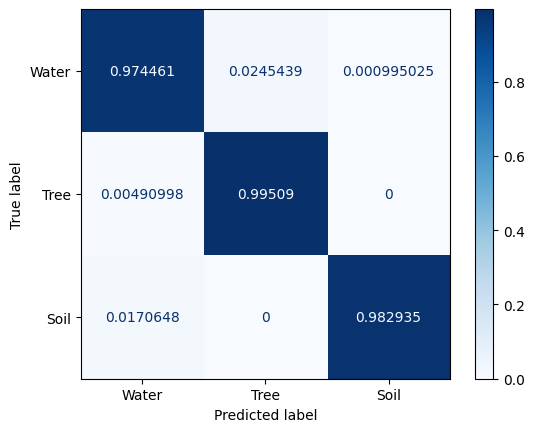

In [193]:
#Samson Linear SVMBDT 

samson_tree = {0: [[1],[0,2]], 1: [[],[[0],[2]]]}

iter = 1e6

samson_svm_tree = {0: SVC(kernel="linear",class_weight= "balanced", max_iter=iter), 
                  1 : [False,SVC(kernel="linear",class_weight= "balanced", max_iter=iter)]}

svm_tree_branch, data_and_labels_branches = SvmDesionTreeTrain(X_train, y_train, samson_tree, samson_svm_tree, sub_data=1)

predicted_label, sub_data_branch, predicted_branch_labels = SvmDesionTreePredict(X, svm_tree_branch, samson_tree, sub_data = 1)

total_accuracy = (predicted_label == y).sum()/len(y)

print("Samson : Linear SMVBDT")

print("Total Accuracy: ", str(round(100*total_accuracy,3)), "%")

try: 
    mean_accuracy = MeanAccuracy(data_and_labels_branches, predicted_branch_labels)

    print("Mean Accuracy: ", str(round(100*mean_accuracy,3)), "%")

except: 
    None

samson_support_vectors = SupportVectorsSvmBranches(svm_tree_branch)

samson_total_vectors, samson_mean_vectors = TotalAndMeanSupportVectors(samson_support_vectors)

print("Total Support Vectors: " + str(samson_total_vectors))

print("Mean Support Vectors: " + str(samson_mean_vectors))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Water", "Tree", "Soil"]

cm = confusion_matrix(y,predicted_label, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
disp = cmd_obj.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()


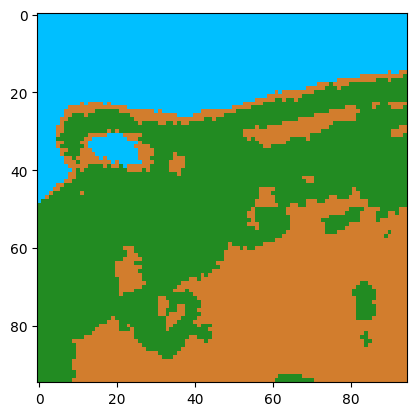

In [169]:
samson_color_label = {0 : [210, 125, 45], 1 : [34,139,34], 2 : [0,191,255]}

shape = int(np.sqrt(len(predicted_label)))

predicted_label_color = newColorLabels(predicted_label,shape,samson_color_label)

plt.imshow(predicted_label_color)

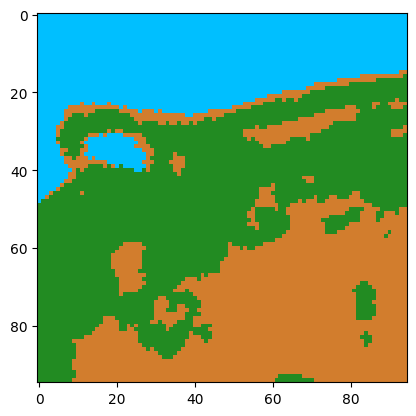

In [170]:
shape = int(np.sqrt(len(y)))

y_color = newColorLabels(y,shape,samson_color_label)

plt.imshow(y_color)

The training time is: 0.005 sec.
The prediction time is: 0.136 sec.
Samson : Linear SMVBDT
Total Accuracy:  94.404 %
Total Support Vectors: 114
Mean Support Vectors: 28.5


C:\Users\jonas\AppData\Local\Temp\ipykernel_42144\4051820884.py:340: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = sum(data_and_labels_branch[0][1] == sub_predicted_labels[0])/len(data_and_labels_branch[0][1])


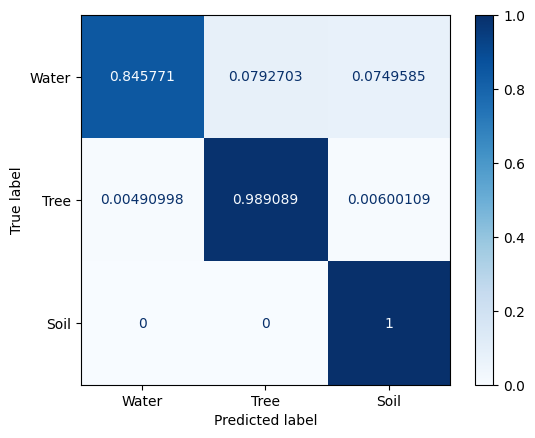

In [194]:
#Samson RBF SVMBDT 

samson_tree = {0: [[1],[0,2]], 1: [[],[[0],[2]]]}

iter = 1e6

samson_svm_tree = {0: SVC(kernel="rbf",class_weight= "balanced", max_iter=iter), 
                  1 : [False,SVC(kernel="rbf",class_weight= "balanced", max_iter=iter)]}

svm_tree_branch, data_and_labels_branches = SvmDesionTreeTrain(X_train, y_train, samson_tree, samson_svm_tree, sub_data=1)

predicted_label, sub_data_branch, predicted_branch_labels = SvmDesionTreePredict(X, svm_tree_branch, samson_tree, sub_data = 1)

total_accuracy = (predicted_label == y).sum()/len(y)

print("Samson : Linear SMVBDT")

print("Total Accuracy: ", str(round(100*total_accuracy,3)), "%")

try: 
    mean_accuracy = MeanAccuracy(data_and_labels_branches, predicted_branch_labels)

    print("Mean Accuracy: ", str(round(100*mean_accuracy,3)), "%")

except: 
    None

samson_support_vectors = SupportVectorsSvmBranches(svm_tree_branch)

samson_total_vectors, samson_mean_vectors = TotalAndMeanSupportVectors(samson_support_vectors)

print("Total Support Vectors: " + str(samson_total_vectors))

print("Mean Support Vectors: " + str(samson_mean_vectors))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Water", "Tree", "Soil"]

cm = confusion_matrix(y,predicted_label, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
disp = cmd_obj.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()


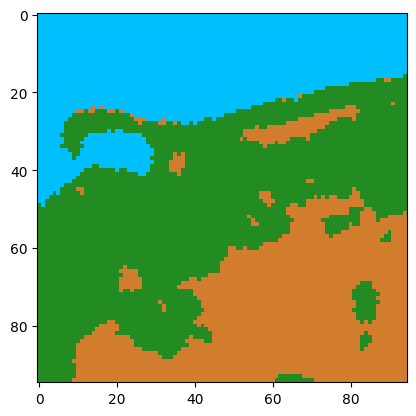

In [179]:
samson_color_label = {0 : [210, 125, 45], 1 : [34,139,34], 2 : [0,191,255]}

shape = int(np.sqrt(len(predicted_label)))

predicted_label_color = newColorLabels(predicted_label,shape,samson_color_label)

plt.imshow(predicted_label_color)

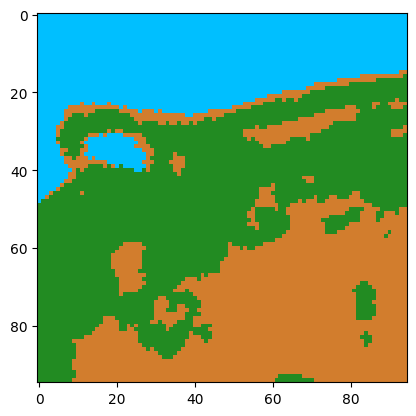

In [180]:
shape = int(np.sqrt(len(y)))

y_color = newColorLabels(y,shape,samson_color_label)

plt.imshow(y_color)

In [214]:
#Single SVM Linear and RBF
def SingleSVMTest(data, train_data, train_label): 

    import time

    samson_svm_linear = SVC(kernel="linear",class_weight= "balanced", max_iter=iter)
    samson_svm_rbf = SVC(kernel="rbf",class_weight= "balanced", max_iter=iter)

    start_time = time.time()

    samson_svm_linear.fit(train_data, train_label)

    stop_time = time.time() 

    print("Linear Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    start_time = time.time()

    samson_svm_rbf.fit(train_data, train_label)

    stop_time = time.time() 

    print("RBF Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    start_time = time.time()

    linear_yout = samson_svm_linear.predict(data)

    stop_time = time.time()

    print("Linear Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    start_time = time.time()

    rbf_yout = samson_svm_rbf.predict(data)

    stop_time = time.time()

    print("RBF Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    print("Linear Accuracy: " + str(100*round(sum(linear_yout == y)/len(y),3)) + "%")
    print("RBF Accuracy: " + str(100*round(sum(rbf_yout == y)/len(y),3)) + "%" )

    print("Linear Total SVM Support_Vectors : " + str(sum(samson_svm_linear.n_support_)))
    print("RBF Total SVM Support_Vectors : " + str(sum(samson_svm_rbf.n_support_)))

    return linear_yout, rbf_yout

In [215]:
linear_yout, rbf_yout = SingleSVMTest(X,X_train, y_train)

Linear Training Time: 0.003sec.
RBF Training Time: 0.003sec.
Linear Predict Time: 0.015sec.
RBF Predict Time: 0.118sec.
Linear Accuracy: 98.7%
RBF Accuracy: 94.8%
Linear Total SVM Support_Vectors : 38
RBF Total SVM Support_Vectors : 95


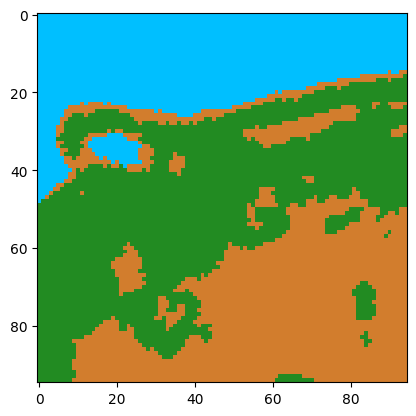

In [216]:
shape = int(np.sqrt(len(linear_yout)))

linear_yout_color = newColorLabels(linear_yout,shape,samson_color_label)

plt.imshow(linear_yout_color)

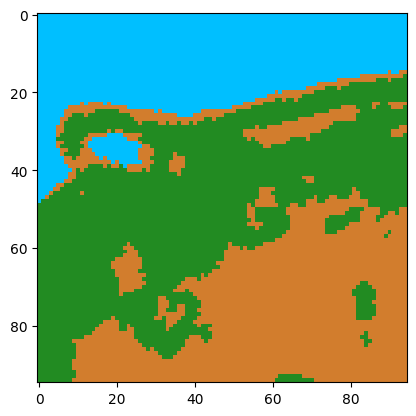

In [207]:
shape = int(np.sqrt(len(rbf_yout)))

rbf_yout_color = newColorLabels(linear_yout,shape,samson_color_label)

plt.imshow(rbf_yout_color)